In [1]:
%matplotlib inline
import os
import sys
import math
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

from numpy import ma
import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter

new_path = r'../tf_netbuilder'
sys.path.append(new_path)


from tf_netbuilder_ext.extensions import register_tf_netbuilder_extensions

register_tf_netbuilder_extensions()

thre1 = 0.1

# Evaluate openpose model based on Mobilenet V3 as a backbone

In [21]:
from models.openpose_singlenet import create_openpose_singlenet

# Uncomment the relevant section: 1) pretrained model OR 2) model with loaded checkpoint

model = create_openpose_singlenet(pretrained=True)

# model = create_openpose_singlenet(pretrained=False)
# weights_path = "output_singlenet/0620_epoch300/openpose_singlenet" # weights trained from scratch 
# model.load_weights(weights_path)

### Load a sample image

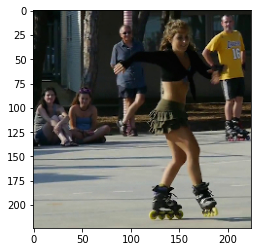

In [22]:
test_image = 'resources/ski_224.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

### (Option 1) Run prediction as is (no multiscale) 

Output shape (heatmap): (1, 28, 28, 19)
Output shape (paf): (1, 28, 28, 38)


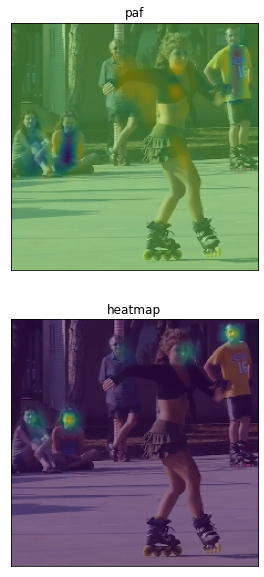

In [23]:
input_img = oriImg[np.newaxis, :, :, [2, 1, 0]]
inputs = tf.convert_to_tensor(input_img)
output_blobs = model.predict(inputs)
    
paf = output_blobs[2]
heatmap = output_blobs[3]
        
print("Output shape (heatmap): " + str(heatmap.shape))
print("Output shape (paf): " + str(paf.shape))
        
heatmap = np.squeeze(heatmap) # output 1 is heatmaps
heatmap_avg = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


    
paf = np.squeeze(paf) # output 0 is PAFs
paf_avg = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

figure = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1, title='paf')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(paf_avg[:, :, 0], alpha=.5)

plt.subplot(2, 1, 2, title='heatmap')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:, :, 0], alpha=.5)

(28, 28, 19)


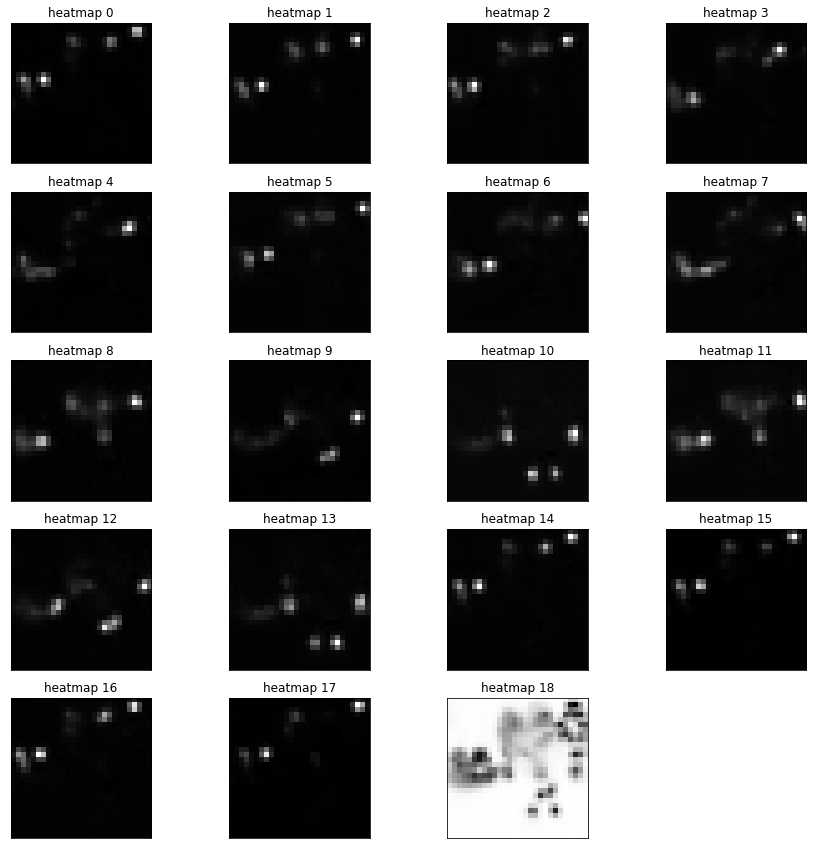

In [5]:
figure = plt.figure(figsize=(15, 15))
print (heatmap.shape)
for i in range(19):
    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(heatmap[:, :, i], cmap='gray')

### (Option 2) Run prediction using miltiple scales

Input shape: (1, 224, 224, 3)
Output shape (heatmap): (1, 28, 28, 19)
Output shape (paf): (1, 28, 28, 38)
Input shape: (1, 224, 224, 3)
Output shape (heatmap): (1, 28, 28, 19)
Output shape (paf): (1, 28, 28, 38)
Input shape: (1, 224, 224, 3)
Output shape (heatmap): (1, 28, 28, 19)
Output shape (paf): (1, 28, 28, 38)
Input shape: (1, 224, 224, 3)
Output shape (heatmap): (1, 28, 28, 19)
Output shape (paf): (1, 28, 28, 38)


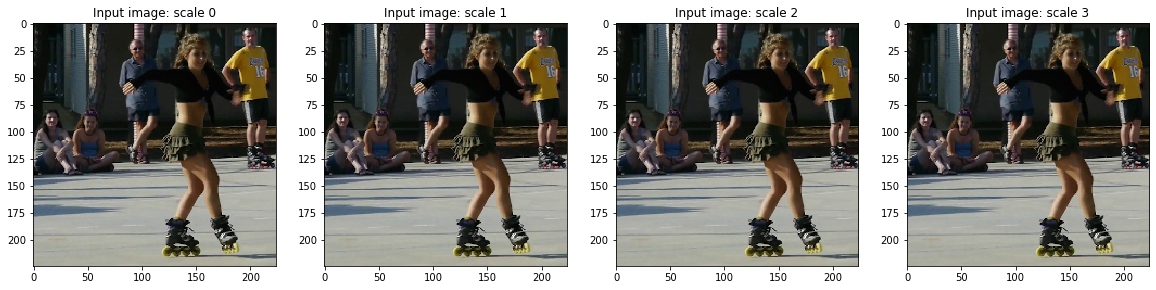

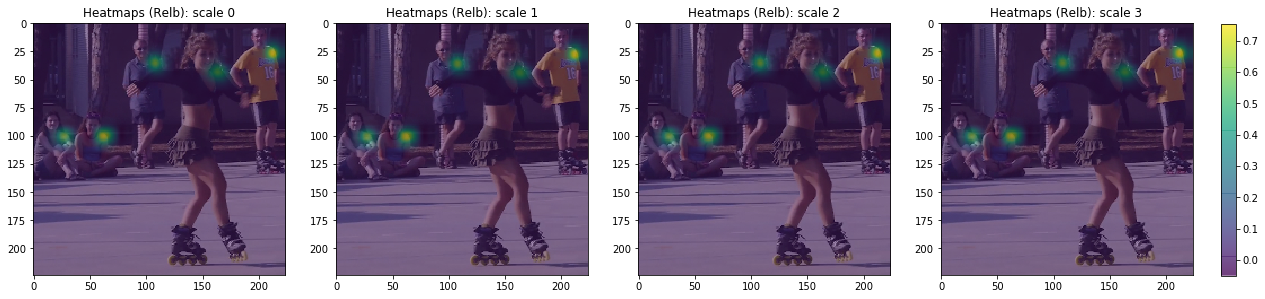

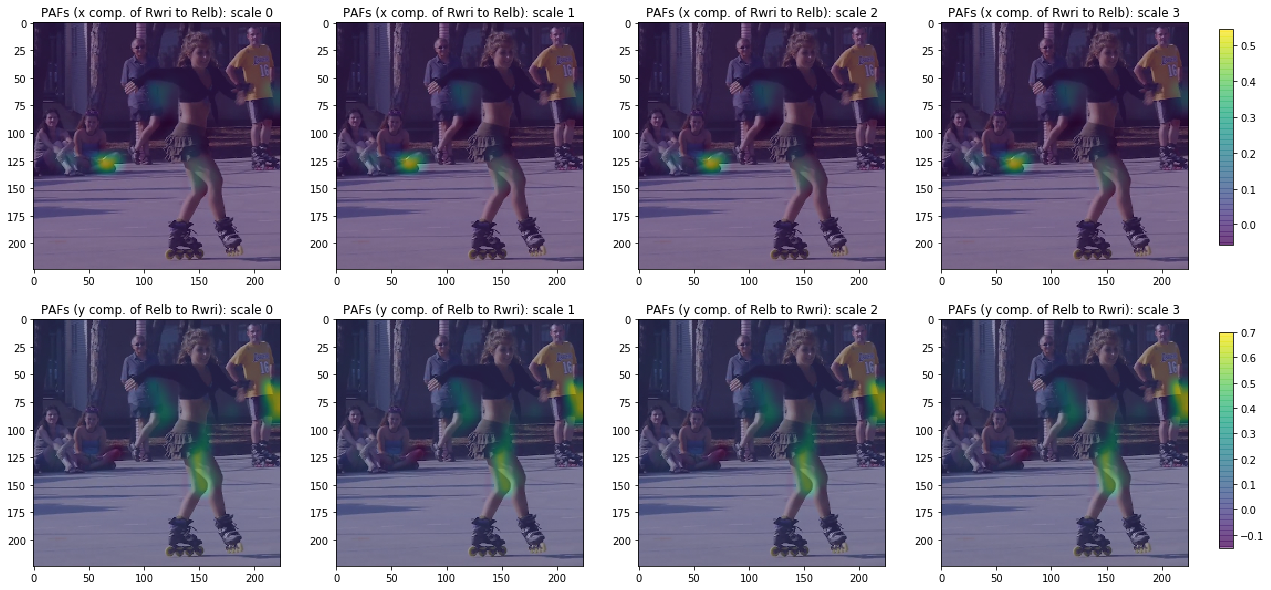

In [4]:
stride = 8
padValue = 128
multiplier = [0.5, 1, 1.5, 2]

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))

for m in range(len(multiplier)):
    scale = multiplier[m]
    #imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest = oriImg
    imageToTest_padded, pad = util.pad_right_down_corner(imageToTest, stride, padValue)        
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    paf = output_blobs[2]
    heatmap = output_blobs[3]
        
    print("Output shape (heatmap): " + str(heatmap.shape))
    print("Output shape (paf): " + str(paf.shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(heatmap) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(paf) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    ax2 = axarr2[m].imshow(heatmap[:,:,5], alpha=.5) # right elbow
    axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
    
    axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    ax3x = axarr3.flat[m].imshow(paf[:,:,8], alpha=.5) # right elbow
    axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
    ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,9], alpha=.5) # right wrist
    axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)

f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy)

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

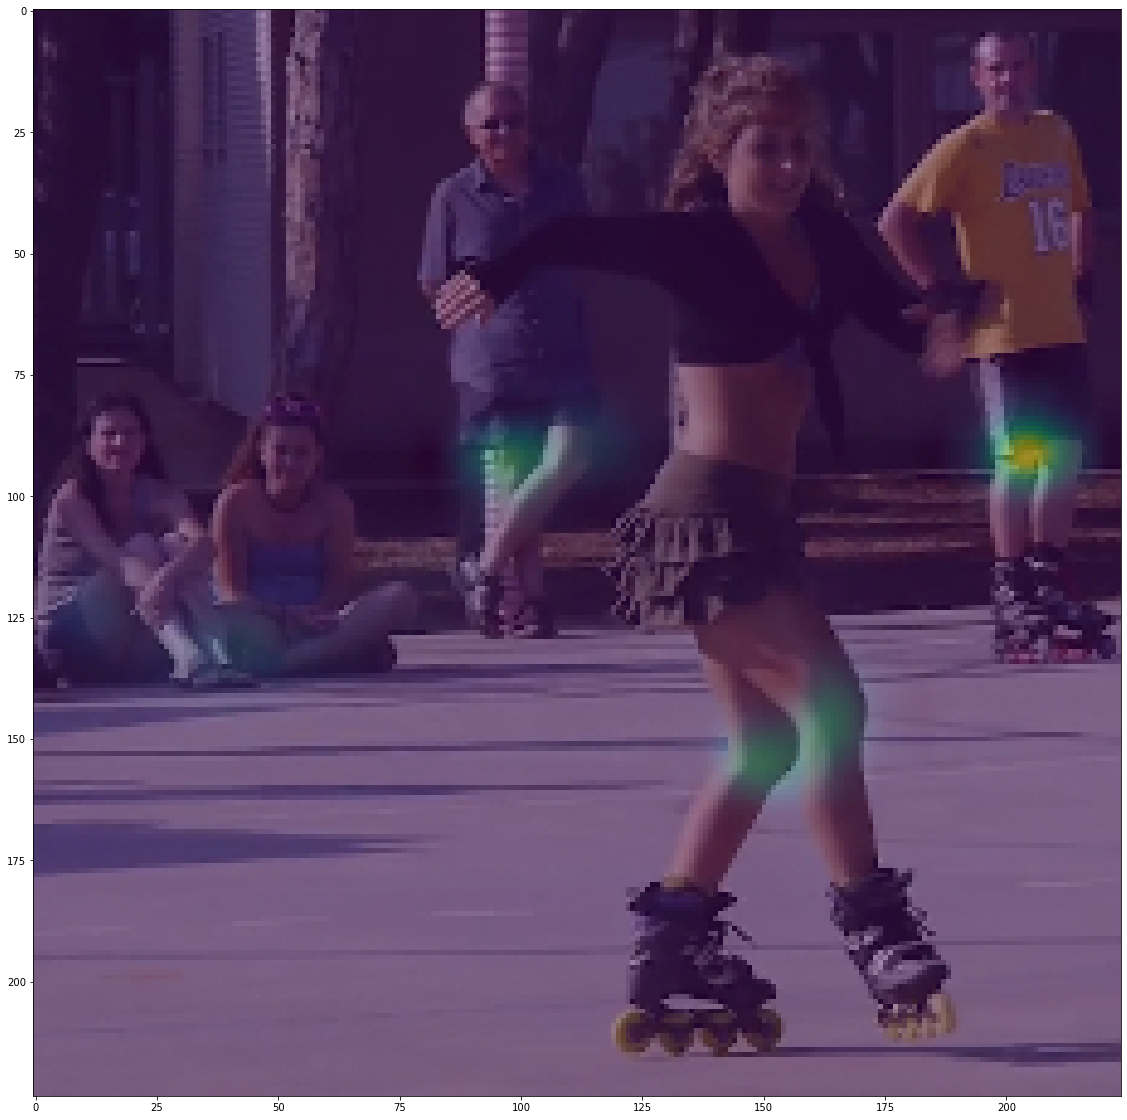

In [5]:
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)

### Sample paf vectors

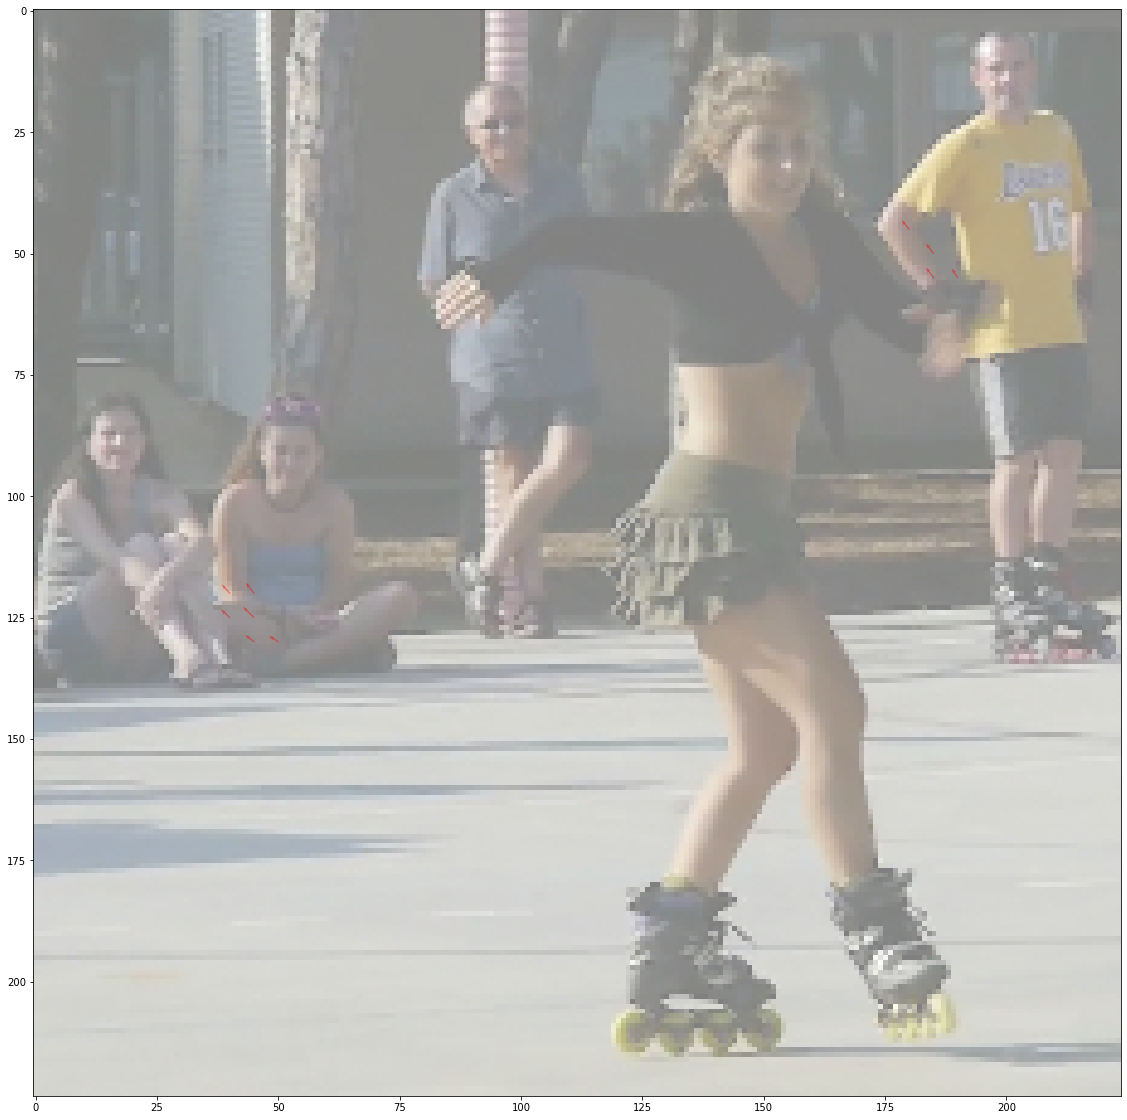

In [6]:
U = paf_avg[:,:,16] * -1
V = paf_avg[:,:,17]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

### Visualise all detected body parts. Note that we use peaks in heatmaps

In [7]:
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > thre1))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [8]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [9]:
thre2 = 0.05
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [10]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [11]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

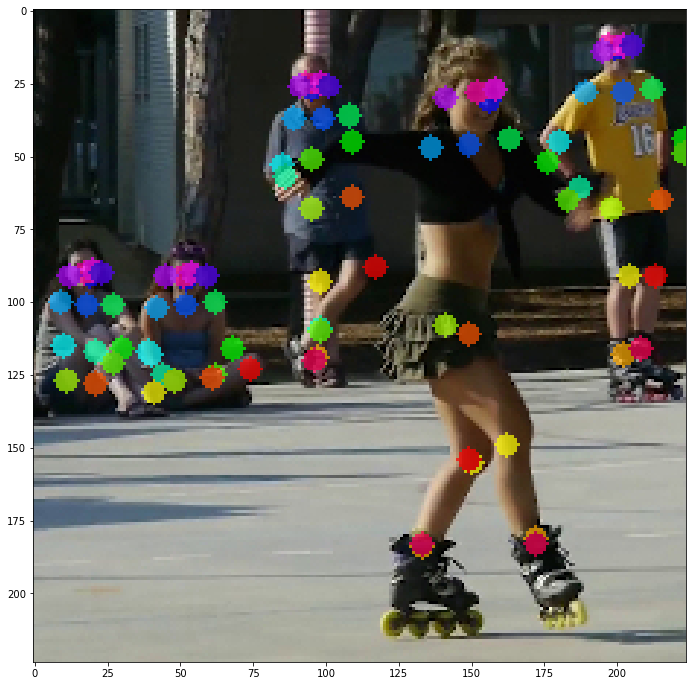

In [12]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

### Link body parts

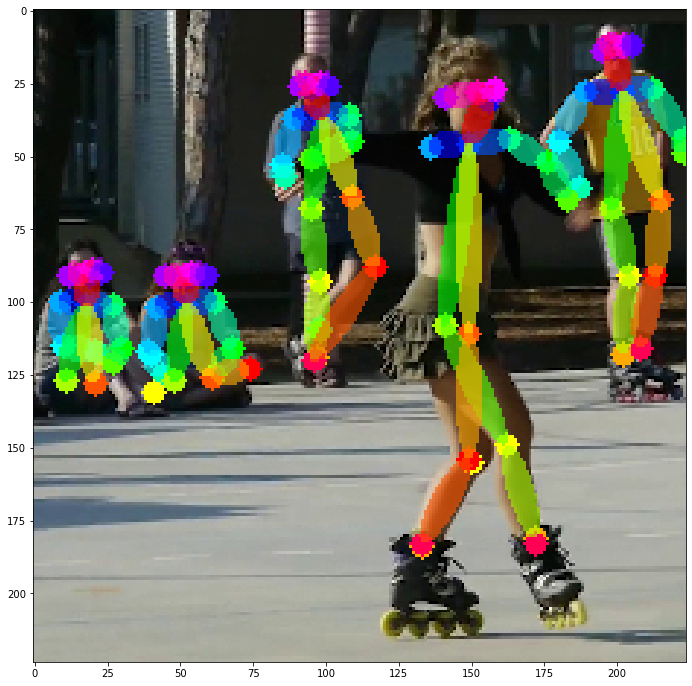

In [13]:
# visualize 2
stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)